# 10: Gradient boosting

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mylib as my

## For regression
**Input**: A training set ${\displaystyle \{(x_{i},y_{i})\}_{i=1}^{n}}$ and a differentiable squared error loss function $${\displaystyle L(y,F(x)) = \frac{1}{2} (y - \gamma)^2}$$.

* $F_0(x) = \underset{\gamma}{argmin} \sum_{i=1}^n L(y_i, \gamma) = \bar{y}$
* For $m = 1$ to $M$:
    * Compute the so-called pseudo-residuals:  
      $$r_{im} = - \frac{\partial L(y_i, F_{m-1}(x_i))}{\partial F_{m-1}(x_i)} = (y_i - F_{m-1}(x_i))$$
    * Fit a regression tree (a weak learner) to the training set $\{(x_i, r_{im})\}_{i=1}^n$. 
    * For each leaf node $R_{jm}$, compute the following output value:
        $$\gamma_{jm} = \frac{1}{n_j} \sum_{i=1}^{n_j} r_{im} \quad \mbox{for } j=1,\ldots,J_m $$
    * Update the model: 
        $$F_{m}(x)=F_{m-1}(x)+ \eta \sum_{j=1}^{J_m} \gamma_{jm} \mathbf{1}(x \in R_{jm})$$ where $\eta$ is the learning rate.
* Output $F_M(x)$

Here is some data

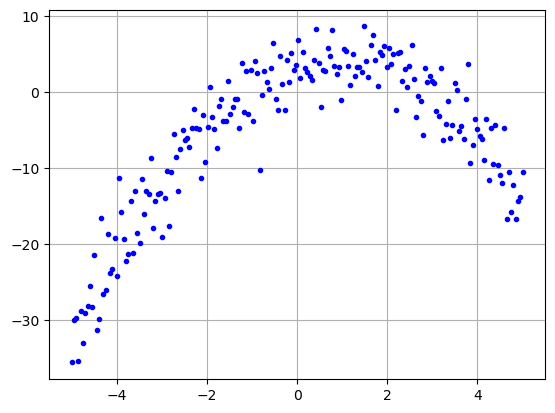

In [2]:
N = 200
x = np.linspace(-5, 5, N)
y = -x**2 + 2 * x + 3 +  3 * np.random.randn(N)
x = x.reshape(N, 1)

plt.plot(x, y, 'b.')
plt.grid()

Calculate the base model

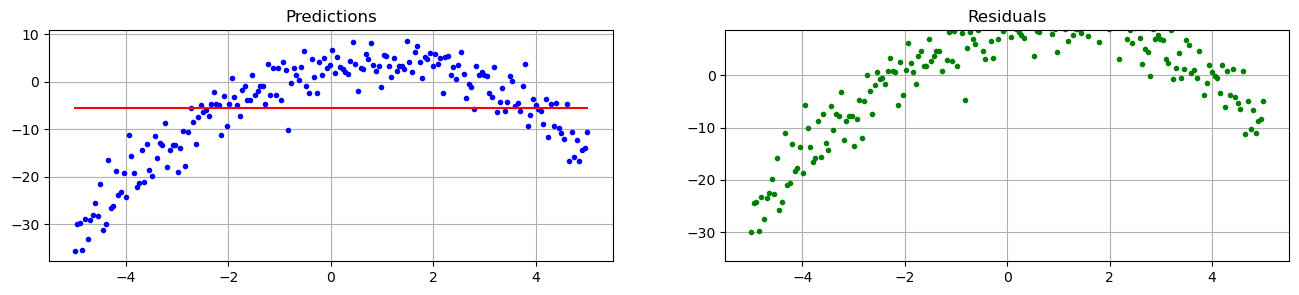

In [3]:
F0 = y.mean()
Fm = np.full(N, F0)

def plot_data_and_predictions(x, y, F, title=None):
    fig = plt.figure(figsize=(16, 3))
    if title is not None:
        fig.suptitle(title, fontsize=16)

    plt.subplot(1,2, 1)
    plt.plot(x, y, 'b.')
    
    if F.ndim == 0:
        plt.plot([x.min(), x.max()], [F, F], 'r-')
    else:
        plt.plot(x, F, 'r-')
    plt.grid()
    plt.title("Predictions")
    
    
    plt.subplot(1, 2, 2)
    r = y - F
    plt.plot(x, r, 'g.')
    plt.grid()
    plt.ylim([y.min(), y.max()])
    plt.title("Residuals")
    
    
plot_data_and_predictions(x, y, Fm)

Next we train the first tree on the residuals

In [4]:
trees = []

In [5]:
from sklearn.tree import DecisionTreeRegressor

rm = y - Fm
tree =  DecisionTreeRegressor(max_depth=3)
tree.fit(x, rm)
Fm += .3 * tree.predict(x)

trees.append(tree)

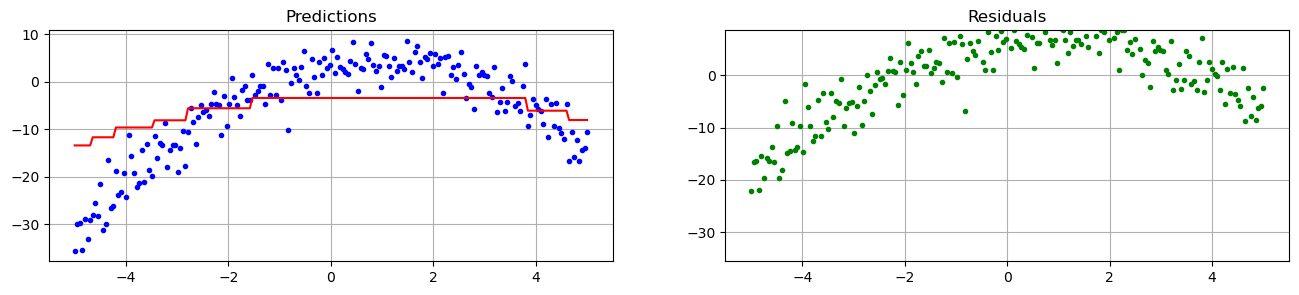

In [6]:
plot_data_and_predictions(x, y, Fm)

Let's add another tree:

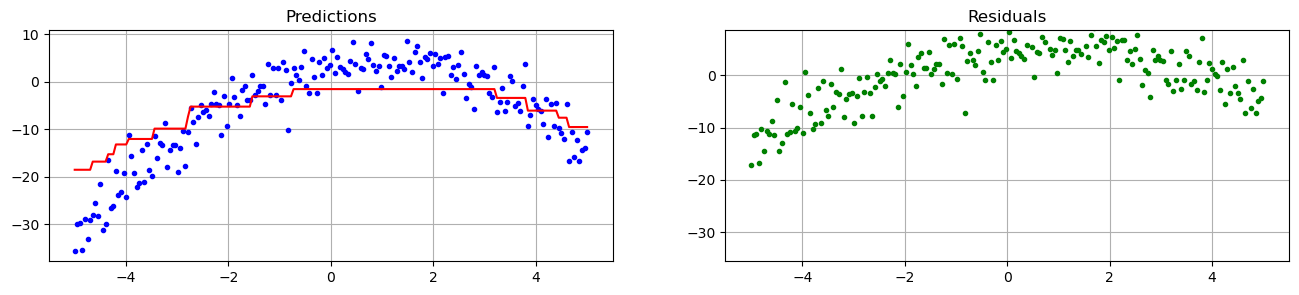

In [7]:
rm = y - Fm
tree =  DecisionTreeRegressor(max_depth=3)
tree.fit(x, rm)
Fm += .3 * tree.predict(x)

trees.append(tree)

plot_data_and_predictions(x, y, Fm)

Let's add 10 more trees:

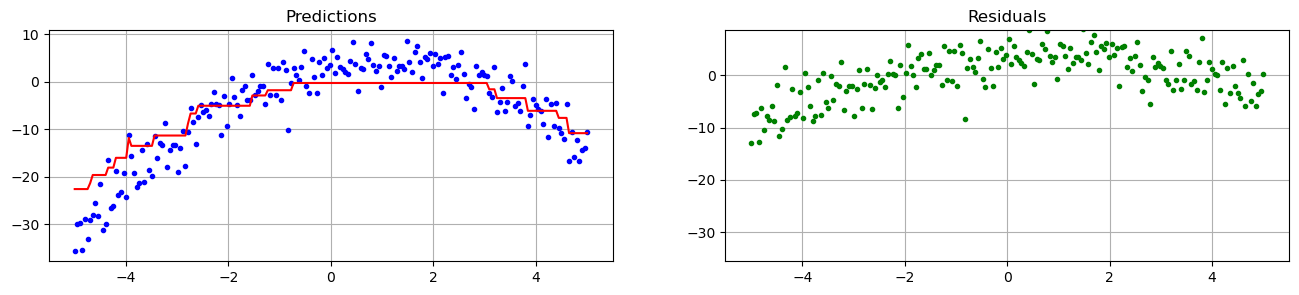

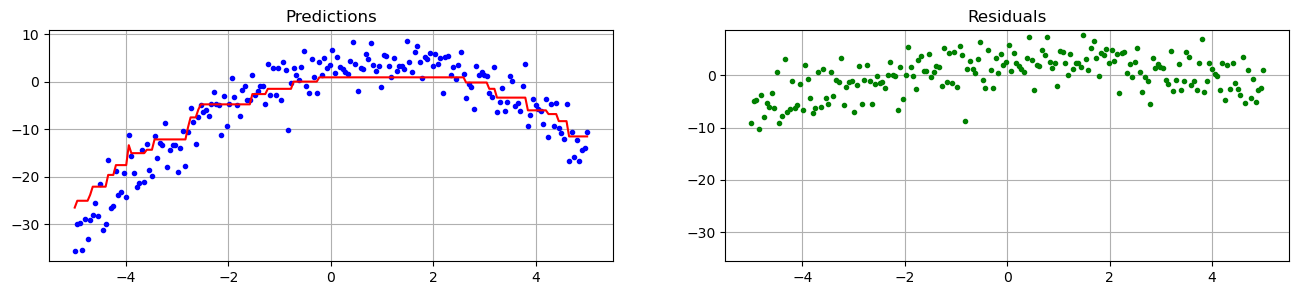

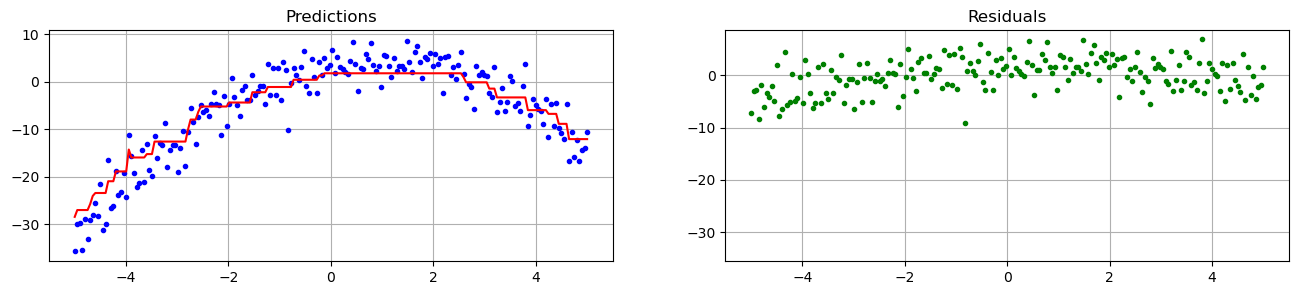

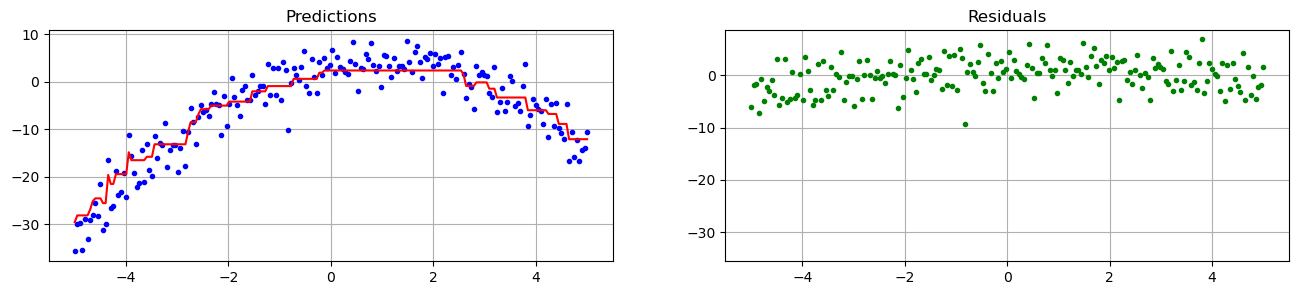

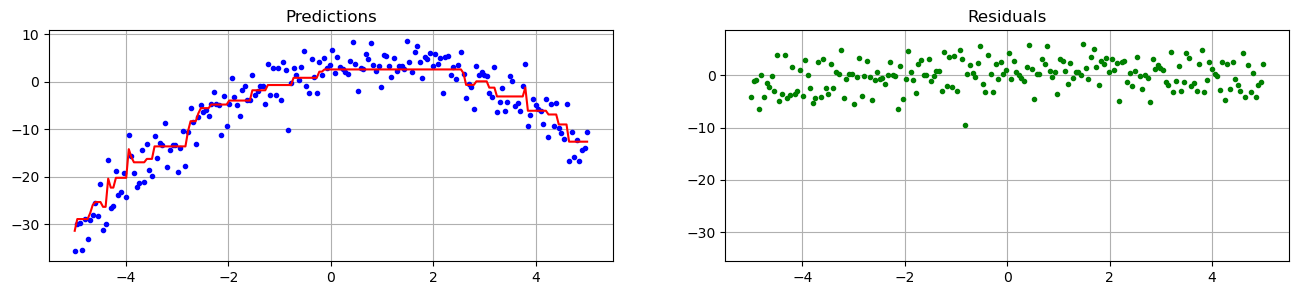

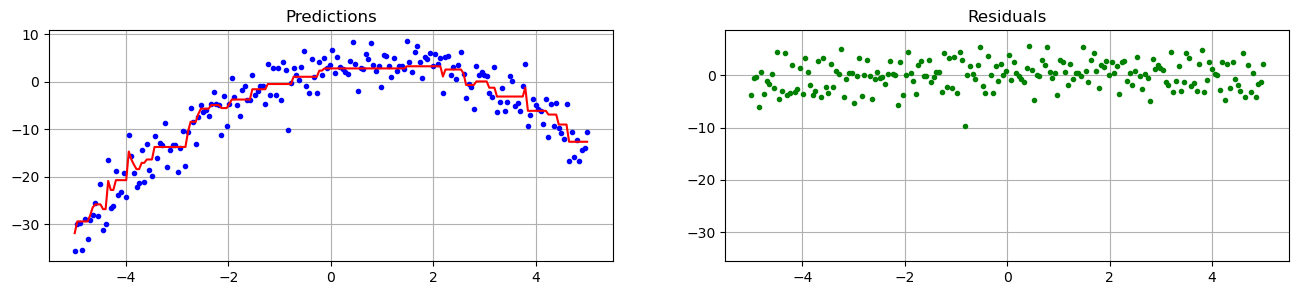

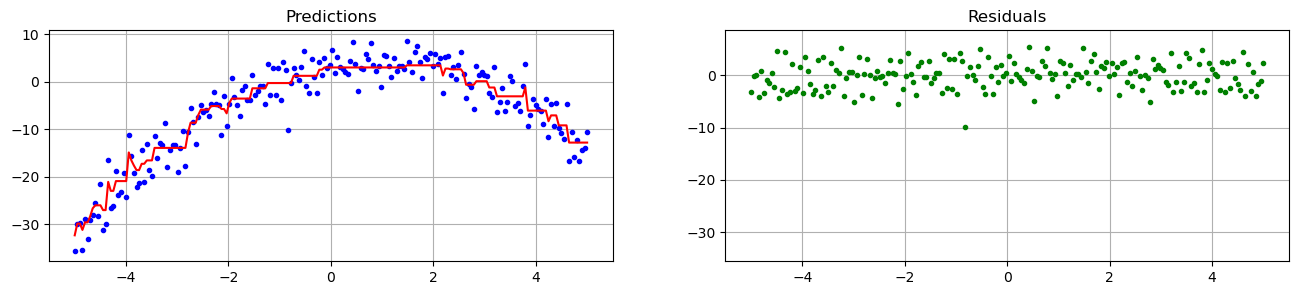

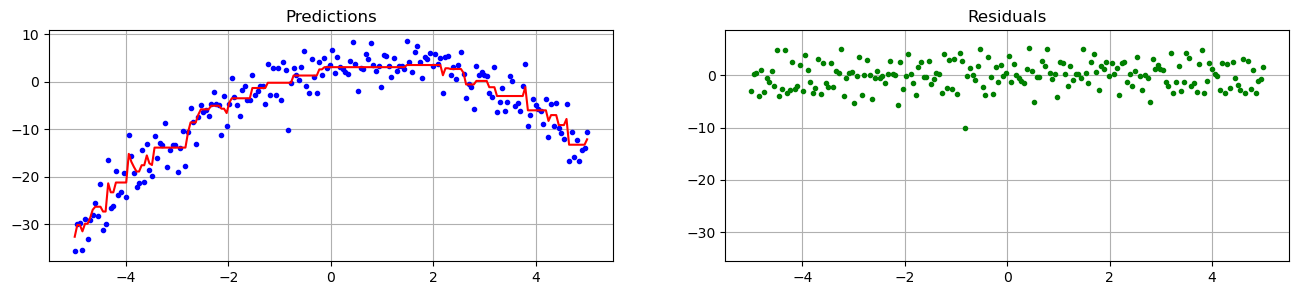

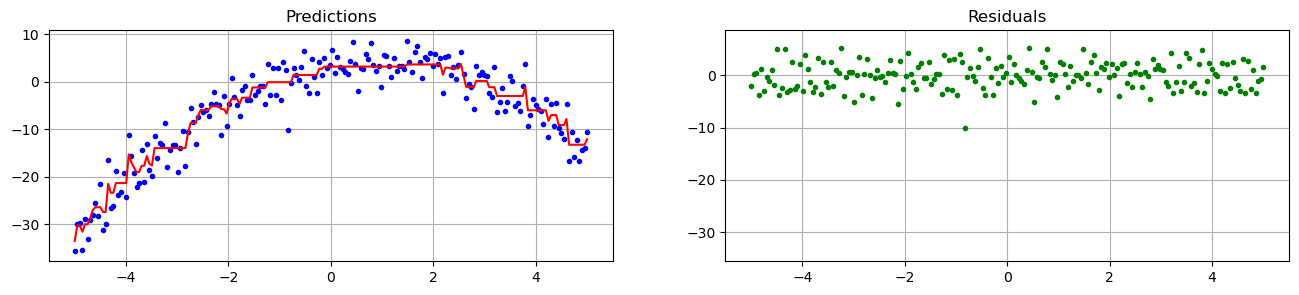

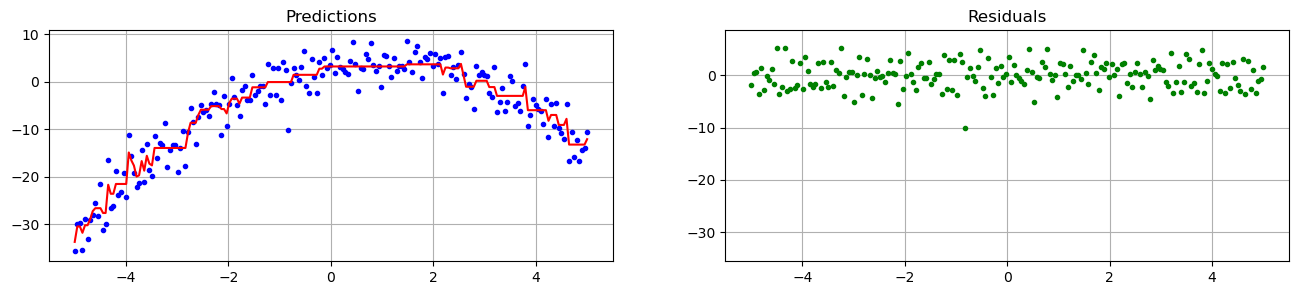

In [8]:
for i in range(10):
    rm = y - Fm
    tree =  DecisionTreeRegressor(max_depth=3)
    tree.fit(x, rm)
    Fm += .3 * tree.predict(x)

    trees.append(tree)

    plot_data_and_predictions(x, y, Fm)

## The effect of learning rate

In [9]:
N = 400
x = np.linspace(0,2,N)
y = np.sin(3*np.pi*x) + np.cos(4*np.pi*x) + np.random.randn(N)*.3
x = x.reshape(N, 1)
x.shape, y.shape

((400, 1), (400,))

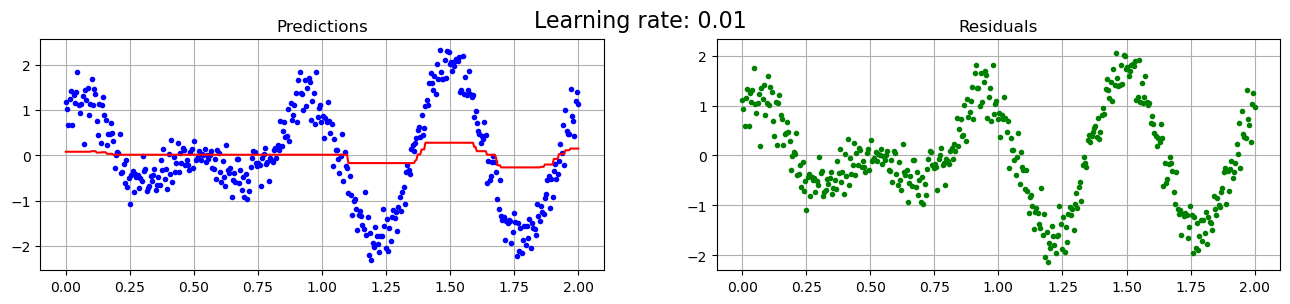

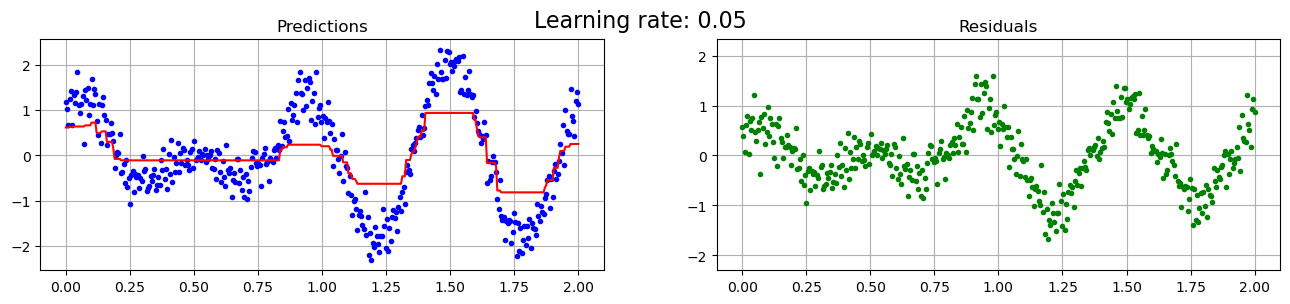

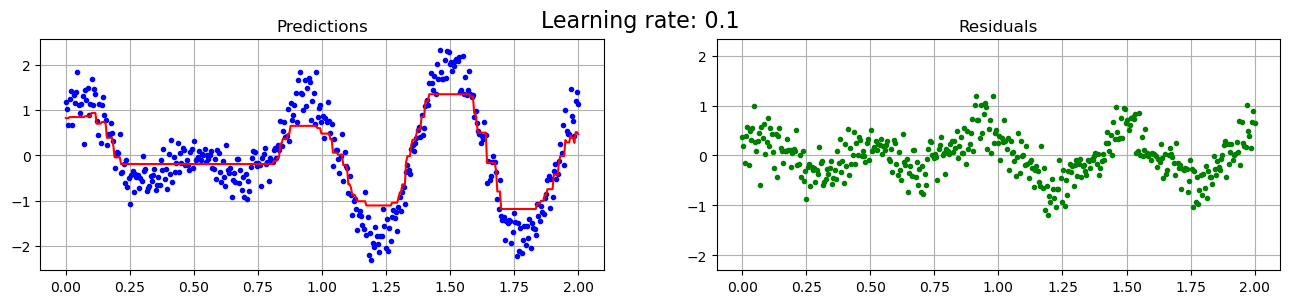

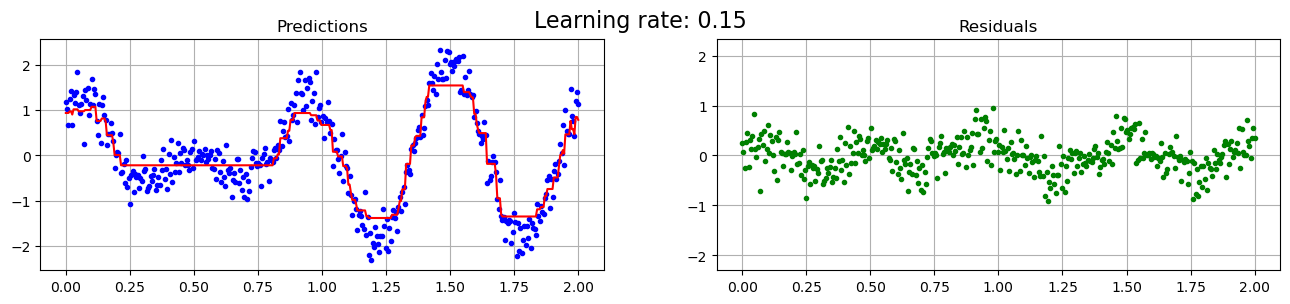

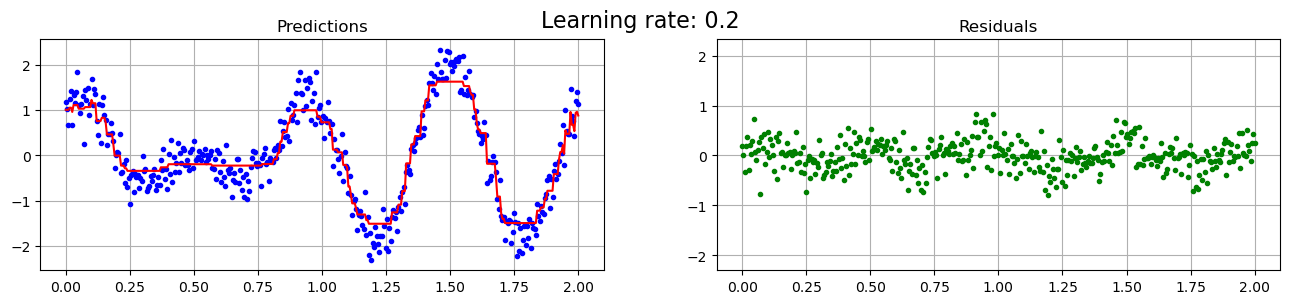

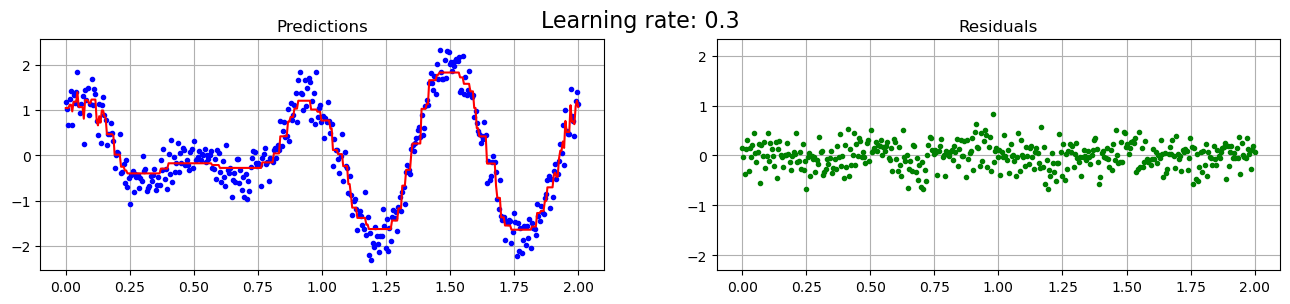

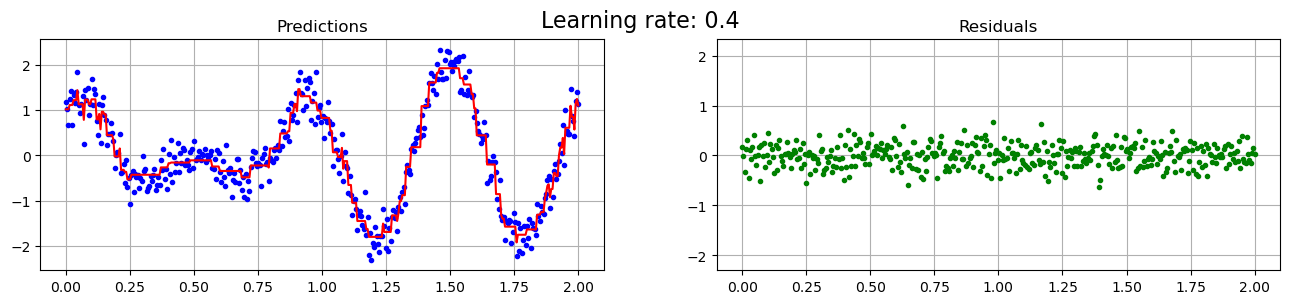

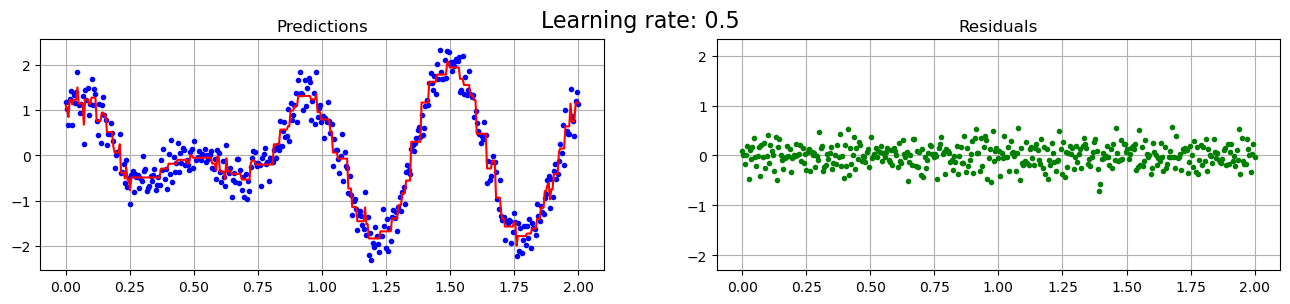

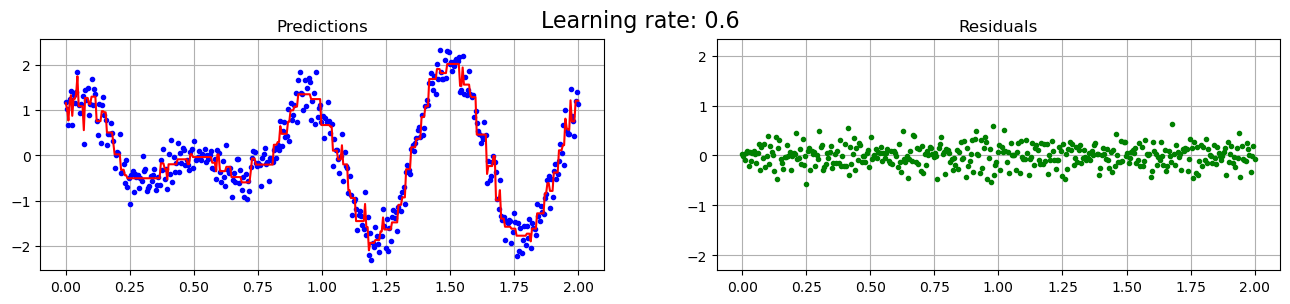

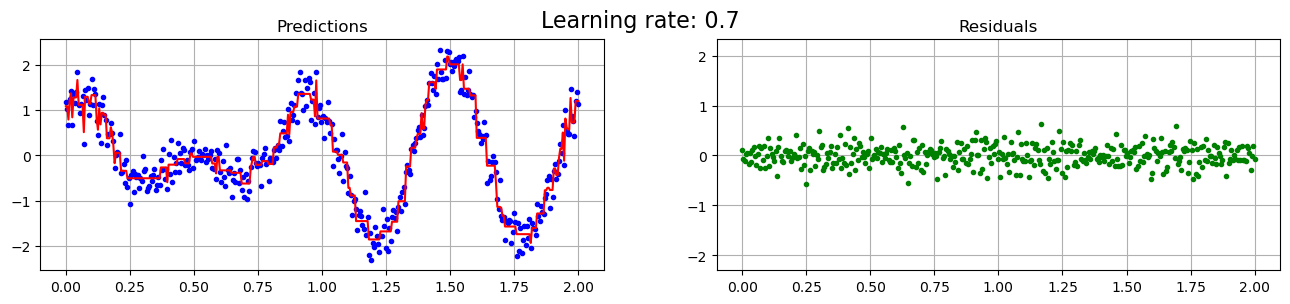

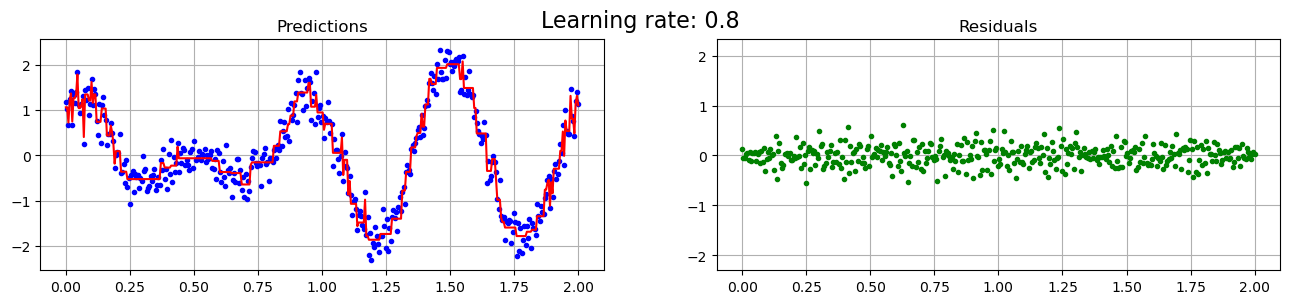

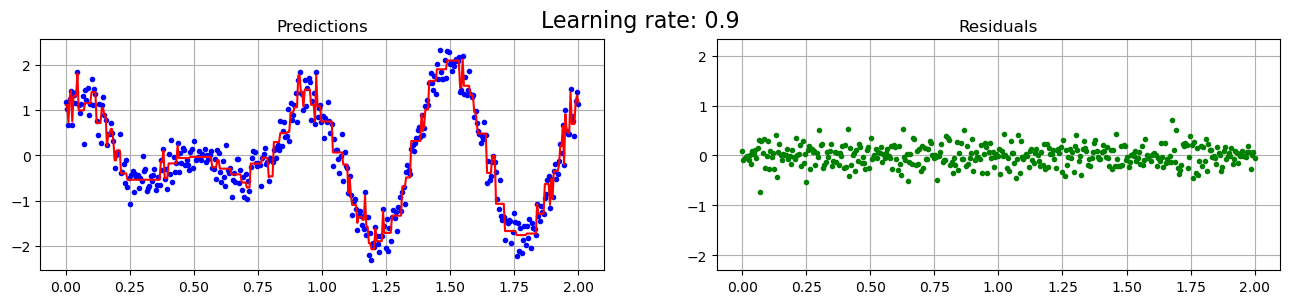

In [10]:
learning_rates = [0.01, 0.05, 0.1, 0.15, .2, .3, .4, .5, .6, .7, .8, .9]

for eta in learning_rates:
    F0 = y.mean()
    Fm = np.full(N, F0)
    trees = []
    for i in range(20):
        rm = y - Fm
        tree =  DecisionTreeRegressor(max_depth=3)
        tree.fit(x, rm)
        Fm += eta * tree.predict(x)

        trees.append(tree)

    plot_data_and_predictions(x, y, Fm, title=f"Learning rate: {eta}")

Let's put this in a class.

In [11]:
from sklearn.tree import DecisionTreeRegressor
class GradientBoostingFromScratch():
    
    def __init__(self, n_trees, learning_rate, max_depth=2):
        self.n_trees=n_trees
        self.learning_rate=learning_rate
        self.max_depth=max_depth;
        
    def fit(self, x, y):
        self.trees = []
        self.F0 = y.mean()
        Fm = self.F0
        for _ in range(self.n_trees):
            tree = DecisionTreeRegressor(max_depth=self.max_depth)
            tree.fit(x, y - Fm)
            Fm += self.learning_rate * tree.predict(x)
            self.trees.append(tree)
            
    def predict(self, x):
        return self.F0 + self.learning_rate * np.sum([tree.predict(x) for tree in self.trees], axis=0)

## For lassification
### The log-loss
* The log-loss is defined as: $$ L(x_i, y_i) = - \sum_c y_{ic} log (p_{ic}) $$
* For binary classification, this function is written as:
    $$ L(x_i, y_i) = - y_{i} log(p_{i}) - (1 - y_i) log(1 - p_i) $$
    which is equivalent to:
      $$ L(x_i, y_i) = {\begin{cases} -log(p_i) & {\text{if }}y_i = 1 \\ -log(1 - p_i)&{\text{if }}y_i = 0 \end{cases}}$$
* This can be written as:
      $$\begin{aligned}L(x_i, y_i)&= - y_{i} log(p_{i}) - log(1 - p_i) + y_i log(1 - p_i)\\
                                  &= - y_{i} log(\frac{p_{i}}{log(1 - p_i)}) - log(1 - p_i)\\
                                  &= - y_{i} \gamma - log(1 - p_i)\\
                                  &= - y_i \gamma - log(1 + e^{\gamma})
      \end{aligned}$$
      where $\gamma = log(odds)= log(\frac{p_{i}}{log(1 - p_i)})$ and
      $p_i = \frac{e^\gamma}{1+ e^\gamma}$
  \end{itemize}
  
### The algorithm
**Input**: A training set ${\displaystyle \{(x_{i},y_{i})\}_{i=1}^{n}}$ and a differentiable log-loss function 
$$L(y,F(x)) = - y_i \gamma - log(1 + e^{\gamma})$$ where $\gamma_i = log(odds) = log(\frac{p_i}{1 - p_i})$$.

* $F_0(x) = \underset{\gamma}{argmin} \sum_{i=1}^n L(y_i, \gamma) = log(\frac{\bar{y}}{1 - \bar{y}})$
* For $m = 1$ to $M$:
    * Compute the so-called pseudo-residuals: 
      $$r_{im} = - \frac{\partial L(y_i, F_{m-1}(x_i))}{\partial F_{m-1}(x_i)} = y_i - p_i$$
    * Fit a regression tree (a weak learner) to the training set $\{(x_i, r_{im})\}_{i=1}^n$. 
    * For each leaf node $R_{jm}$, compute the following output value:
        $$\gamma_{jm} = \frac{\sum_{x_i\in R_{jm}} y_i - p_i}{\sum_{x_i\in R_{jm}} p_i(1 - p_i)} \quad \mbox{for } j=1,\ldots,J_m$$
    * Update the model: 
        $$F_{m}(x)=F_{m-1}(x)+ \eta \sum_{j=1}^{J_m} \gamma_{jm} \mathbf{1}(x \in R_{jm})$$ where $\eta$ is the learning rate.

* Output $F_M(x)$

Here is some data:

In [12]:
from sklearn.datasets import make_gaussian_quantiles
X1, y1 = make_gaussian_quantiles(
    cov=3.0, n_samples=200, n_features=2, n_classes=2, random_state=11
)
X2, y2 = make_gaussian_quantiles(
    mean=(4, 3), cov=2.5, n_samples=300, n_features=2, n_classes=2, random_state=11
)
X = np.concatenate((X1, X2))
y = np.where(np.concatenate((y1, -y2 + 1)) == 0, 0, 1)

X.shape, y.shape

((500, 2), (500,))

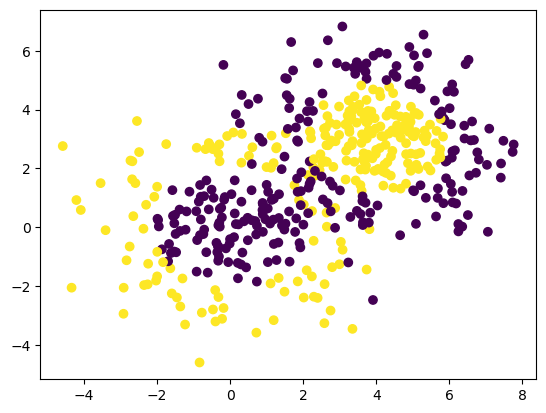

In [13]:
plt.scatter(X[:, 0], X[:, 1],marker="o", c=y)

Here are some useful functions:

In [14]:
from matplotlib.colors import ListedColormap

def make_predictions(X):
    Fm = F0

    for t in trees:
        Fm += learning_rate * t.predict(X)

    p = np.exp(Fm) / (1 + np.exp(Fm))
    return np.where(p <= .5, 0, 1), p

def plot_decision_regions(X, y, resolution=0.1, title="Decision regions", ax=None, figsize=(16,8)):
    if X.ndim != 2:
        raise TypeError("Input data must be two-dimensional. That is the first X param can only have two features.")

    if y.ndim == 1:
        y = y.reshape(len(X), -1)
        
    D = np.concatenate([X, y], axis=1)
    
    if ax is None:
        fig = plt.figure(figsize=figsize)
        ax = fig.add_subplot(1,1,1)
    # Create color maps
    cmap_light = ListedColormap(['#79dfc1', '#feb272', '#a370f7', '#6ea8fe', '#dee2e6', '#ea868f'])
    cmap_bold = ListedColormap(['#20c997', '#fd7e14', '#6610f2', '#0d6efd', '#adb5bd', '#dc3545'])
    
    # Plot the decision boundary.
    x_min, x_max = D[:,0].min() - 1, D[:,0].max() + 1
    y_min, y_max = D[:,1].min() - 1, D[:,1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, resolution),
                         np.arange(y_min, y_max, resolution))
    Z = make_predictions(np.array([xx.ravel(), yy.ravel()]).T)[0]

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.rcParams['pcolor.shading'] ='nearest'
    ax.pcolormesh(xx, yy, Z, cmap=cmap_light)

    # Plot the points
    ax.scatter(
        x=D[:, 0],
        y=D[:, 1], c=D[:,-1], cmap=cmap_bold,
        edgecolor='k', s=60)
    
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

    # plt.legend(loc='best')
    if ax is None:
        plt.title(title)
    else:
        ax.set_title(title)
        
def plot_regions_and_residuals(X, y, r):
    cm = my.confusion_matrix(y, make_predictions(X)[0])
    accuracy = np.trace(cm) / np.sum(cm)

    fig, (ax1, ax2) = plt.subplots(1,2, figsize=(16, 3))
    plot_decision_regions(X, y, resolution=0.5, title=f"Predictions- Accuracy={accuracy}", ax=ax1)
    
    ax2.plot(X[:,0], r, 'g.')
    ax2.grid()
    ax2.set_ylim([r.min(), r.max()])
    ax2.set_title("Residuals")

Here is the base model:

In [15]:
N = len(y)
learning_rate = .3
F0 = np.log(y.mean()/(1-y.mean()))
Fm = np.full(N, F0)
trees = []

Here is the first tree:

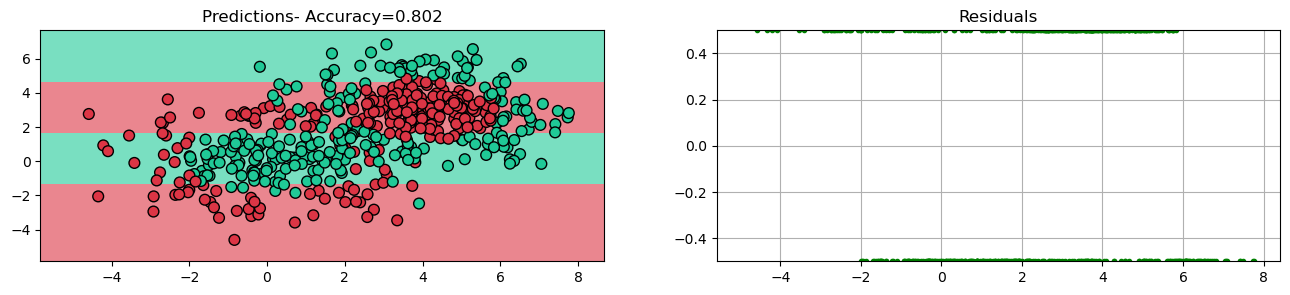

In [16]:
p = np.exp(Fm) / (1 + np.exp(Fm))
r = y - p  # residuals
tree = DecisionTreeRegressor(max_depth=2).fit(X, r)

# getting the ids of the leaves and calculating gamma_jm
ids = tree.apply(X) 
for j in np.unique(ids):
    top_sum = r[ids == j].sum()
    bottom_sum = (p[ids == j]*(1-p[ids == j])).sum()
    gamma_jm = top_sum / bottom_sum

    Fm[ids == j] += learning_rate * gamma_jm

    # Replace gamma_jm for the predicted value the prediction value in the tree
    tree.tree_.value[j, 0, 0] = gamma_jm

trees.append(tree)
plot_regions_and_residuals(X, y, r)

Here is another tree:

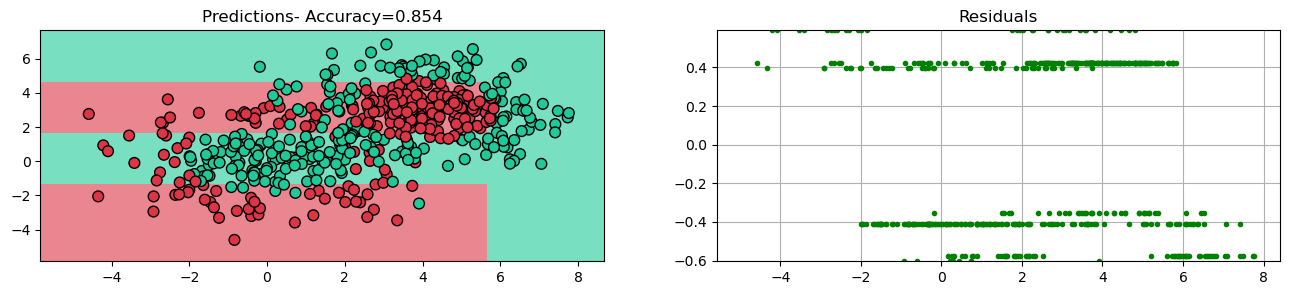

In [17]:
p = np.exp(Fm) / (1 + np.exp(Fm))
r = y - p  # residuals
tree = DecisionTreeRegressor(max_depth=2).fit(X, r)

# getting the ids of the leaves and calculating gamma_jm
ids = tree.apply(X) 
for j in np.unique(ids):
    top_sum = r[ids == j].sum()
    bottom_sum = (p[ids == j]*(1-p[ids == j])).sum()
    gamma_jm = top_sum / bottom_sum

    Fm[ids == j] += learning_rate * gamma_jm

    # Replace gamma_jm for the predicted value the prediction value in the tree
    tree.tree_.value[j, 0, 0] = gamma_jm

trees.append(tree)

plot_regions_and_residuals(X, y, r)

Let's do 10 more trees:

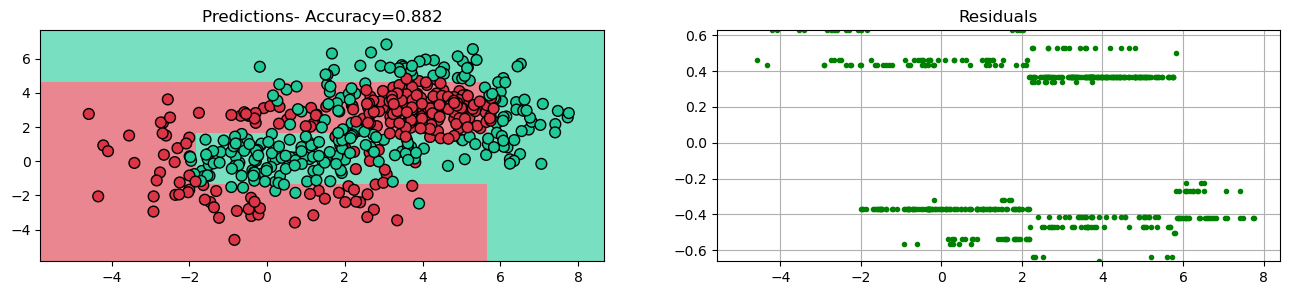

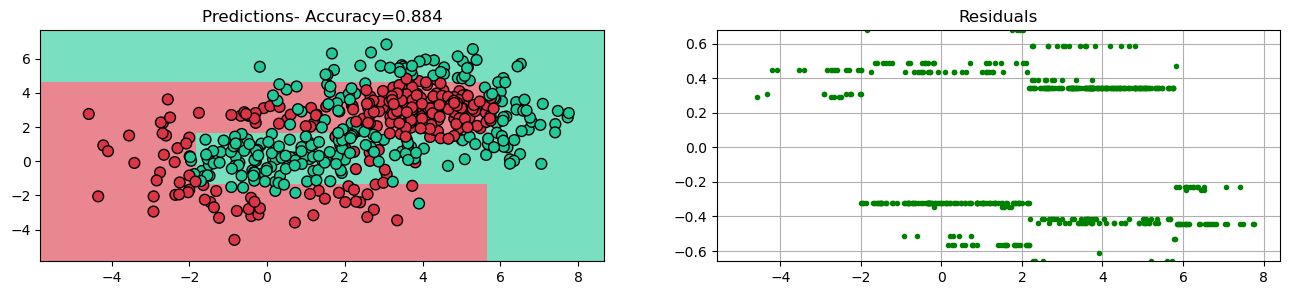

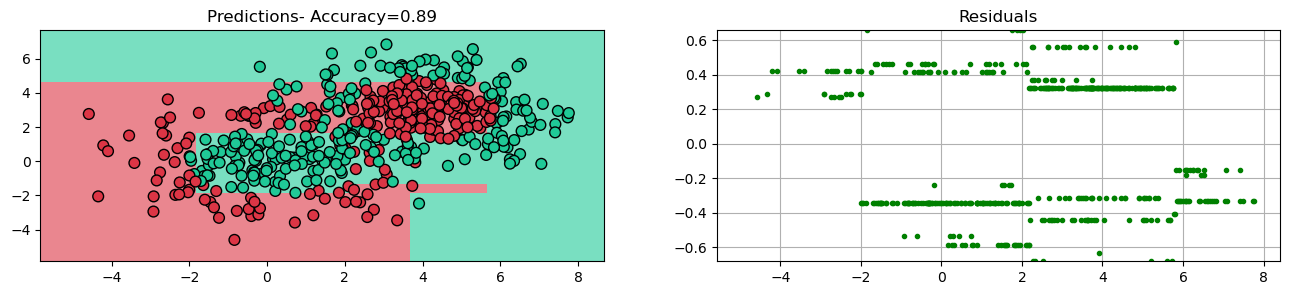

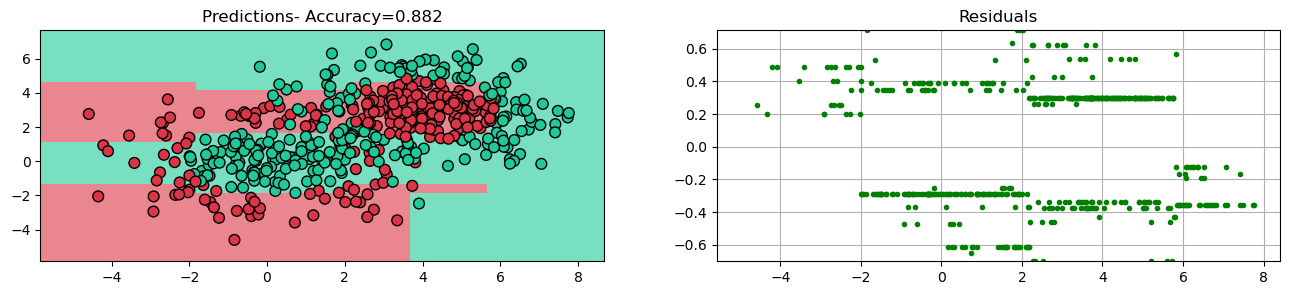

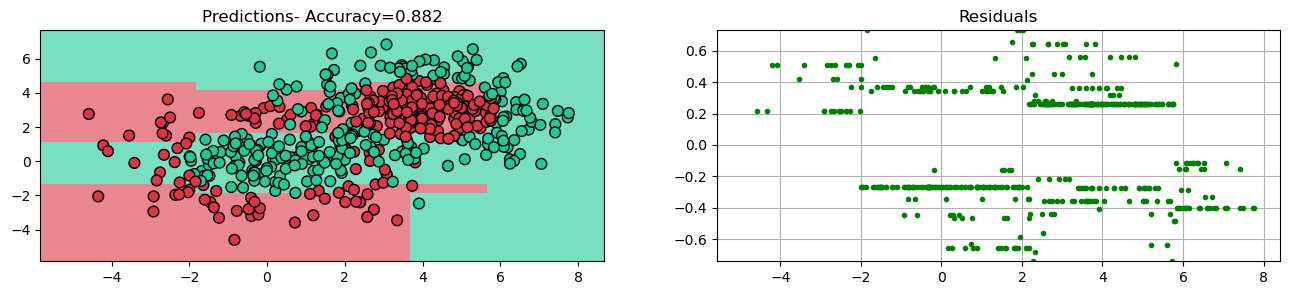

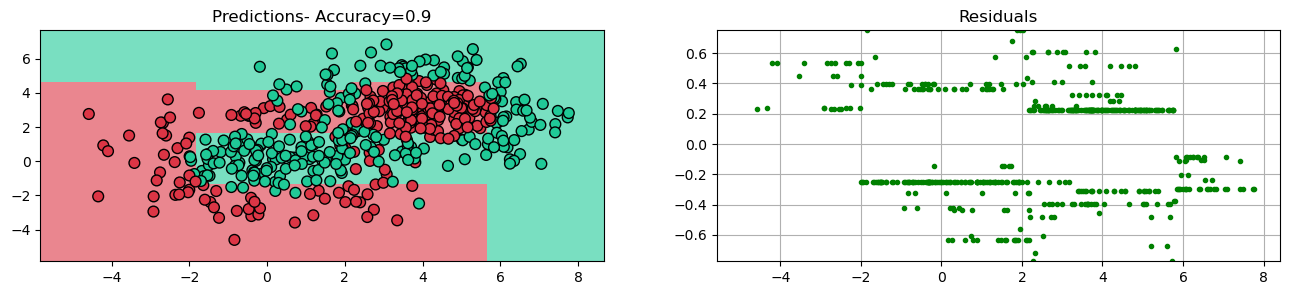

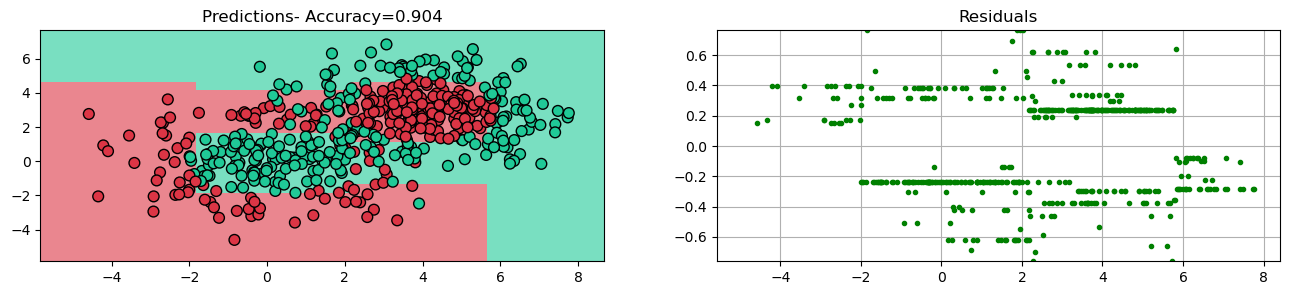

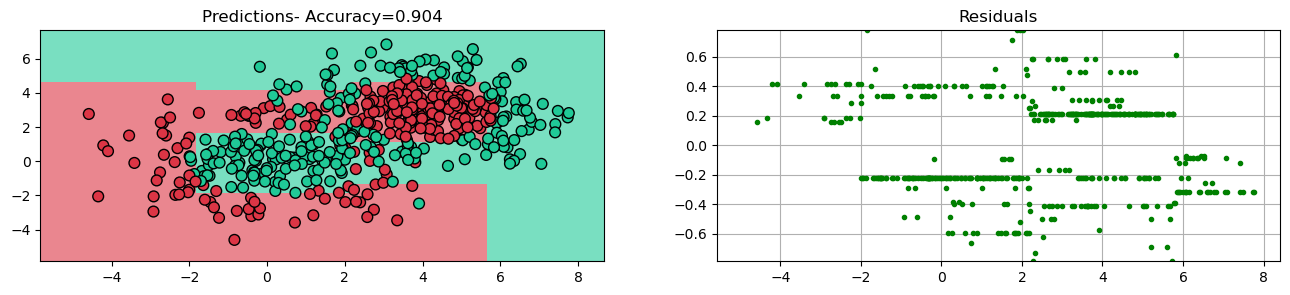

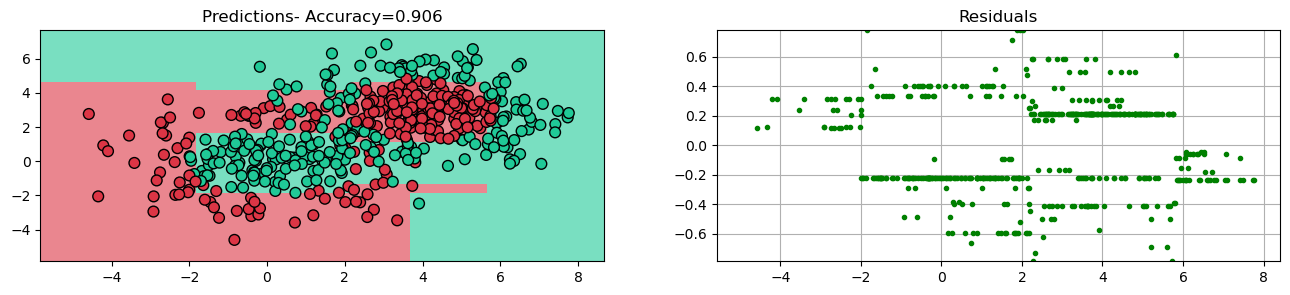

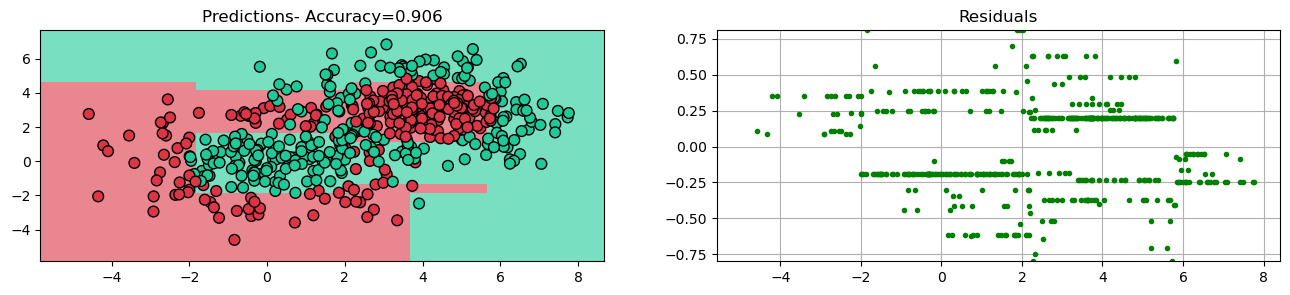

In [18]:
for _ in range(10):
    p = np.exp(Fm) / (1 + np.exp(Fm))
    r = y - p  # residuals
    tree = DecisionTreeRegressor(max_depth=2).fit(X, r)

    # Getting the ids of the leaves and calculating gamma_jm
    ids = tree.apply(X) 
    for j in np.unique(ids):
        top_sum = r[ids == j].sum()
        bottom_sum = (p[ids == j]*(1-p[ids == j])).sum()
        gamma_jm = top_sum / bottom_sum

        Fm[ids == j] += learning_rate * gamma_jm

        # Replace gamma_jm for the predicted value the prediction value in the tree
        tree.tree_.value[j, 0, 0] = gamma_jm

    trees.append(tree)

    plot_regions_and_residuals(X, y, r)

Here is the implementation put together in a class:

In [19]:
class SimpleGradientBoostingClassifier:
    def __init__(self, learning_rate, n_estimators, max_depth=2):
        self.learning_rate = learning_rate
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.trees = []
        
    def fit(self, X, y):
        self.F0 = np.log(y.mean()/(1-y.mean()))
        Fm = np.full(len(y), self.F0)
        
        for m in range(self.n_estimators):
            p = np.exp(Fm) / (1 + np.exp(Fm))
            rm = y - p  # Pseudo-residuals
            tree = DecisionTreeRegressor(max_depth=self.max_depth).fit(X, rm)
            
            # Getting the ids of the leaves and calculating gamma_jm
            ids = tree.apply(X)
            for j in np.unique(ids):
                top_sum = rm[ids == j].sum()
                bottom_sum = (p[ids == j]*(1-p[ids == j])).sum()
                gamma_jm = top_sum / bottom_sum

                Fm[ids == j] += self.learning_rate * gamma_jm

                # Replace gamma_jm for the predicted value the prediction value in the tree
                tree.tree_.value[j, 0, 0] = gamma_jm

            self.trees.append(tree)
            
        return self
    
    def predict(self, X_unseen):
        Fm = self.F0 + self.learning_rate * np.sum([tree.predict(X_unseen) for tree in self.trees], axis=0)
        p = np.exp(Fm) / (1 + np.exp(Fm))
        return np.where(p <= .5, 0, 1)

Let's try it:

In [20]:
from sklearn.datasets import make_gaussian_quantiles
X1, y1 = make_gaussian_quantiles(
    cov=3.0, n_samples=200, n_features=2, n_classes=2, random_state=11
)
X2, y2 = make_gaussian_quantiles(
    mean=(4, 3), cov=2.5, n_samples=300, n_features=2, n_classes=2, random_state=11
)
X = np.concatenate((X1, X2))
y = np.where(np.concatenate((y1, -y2 + 1)) == 0, 0, 1)

X.shape, y.shape

((500, 2), (500,))

In [21]:
# X, y, features, target = my.from_dataframe(data)
print(y.shape)
X_train, X_test, y_train, y_test = my.train_test_split(X, y.ravel(), test_size=.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(500,)


((350, 2), (150, 2), (350,), (150,))

Let's train a model:

In [22]:
gb = SimpleGradientBoostingClassifier(.3, 50, 2).fit(X_train, y_train)

And now we evaluate it:

[[68 11]
 [ 4 67]]
Testing accuracy:  0.9


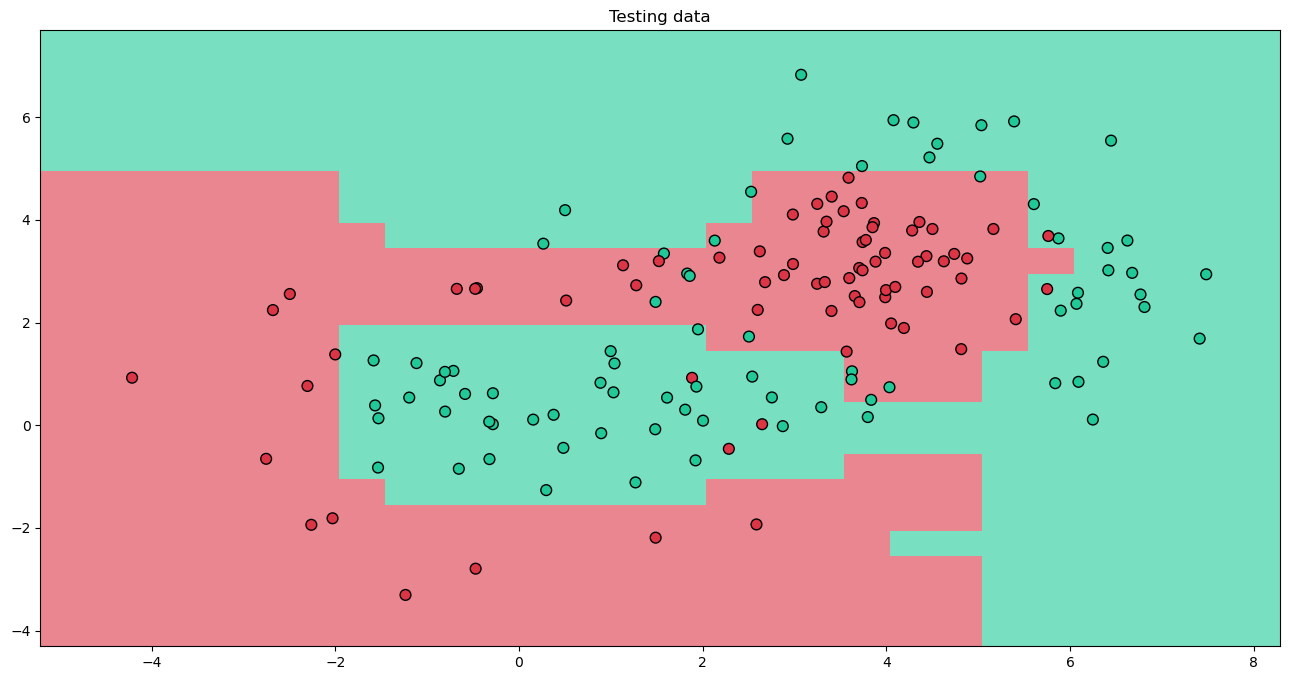

In [23]:
cm = my.confusion_matrix(y_test, gb.predict(X_test))
accuracy = np.trace(cm) / np.sum(cm)

print(cm)
print('Testing accuracy: ', accuracy)

my.plot_decision_regions(X_test, y_test, gb, resolution=0.5, title="Testing data")